In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
import json
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tf2onnx

In [44]:
# with open("b_values.json") as f:
#     b_values = json.load(f)
    
# with open("avg_amplitude_ratios.json") as f:
#     avg_amplitude_ratios = json.load(f)

with open("results.csv") as f:
    results = f.readlines()
    
strings = ["h_E", "B", "G", "D", "A", "E"]
labels = np.array([0,1,2,3,4,5])
# strings = ["1-2h_E", "1-2B", "1-2G", "1-2D", "1-2A", "1-2E", "2-2h_E", "2-2B", "2-2G", "2-2D", "2-2A", "2-2E"]
# labels = np.array([0,1,2,3,4,5,6,7,8,9,10,11])


data = []
label_list = []

for i, line in enumerate(results):
    if i == 0:
        continue
    string,metric,amp_ra,deviation,f0 = line.split(",")
    if string in strings:
        metric = float(metric)
        amp_ra = float(amp_ra)
        deviation = float(deviation)
        f0 = float(f0)
        data.append([metric, amp_ra, deviation, f0])
        label_list.append(labels[strings.index(string)])


data = np.array(data, dtype=np.float32)
label_list = np.array(label_list)


scaler = StandardScaler()
data = scaler.fit_transform(data)

label_count = 6
labels_categorical = tf.keras.utils.to_categorical(label_list, num_classes=label_count)


X_train, X_test, y_train, y_test = train_test_split(data, labels_categorical, test_size=0.2, random_state=42, shuffle=True)

print(f"Training data shape: {X_train.shape}")  # Should be (num_samples, 2)
print(f"Training labels shape: {y_train.shape}")

Training data shape: (708, 4)
Training labels shape: (708, 6)


In [ ]:

model = Sequential([
    Dense(128, activation='relu', input_shape=(4,)),  
    BatchNormalization(),  # Helps stabilize training
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Dense(32, activation='relu'),
    # Dropout(0.2),

    Dense(label_count, activation='softmax') 
])
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0005), metrics=['accuracy'])

# Train the model

print(model.summary())
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.2,callbacks=[early_stopping])

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_72 (Dense)                │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,070 (47.15 KB)

 Trainable params: 11,622 (45.40 KB)

 Non-trainable params: 448 (1.75 KB)

None
Epoch 1/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2164 - loss: 2.4530 - val_accuracy: 0.2254 - val_loss: 1.7590
Epoch 2/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3199 - loss: 1.9890 - val_accuracy: 0.2042 - val_loss: 1.7065
Epoch 3/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3528 - loss: 1.7095 - val_accuracy: 0.2324 - val_loss: 1.6593
Epoch 4/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3730 - loss: 1.6863 - val_accuracy: 0.2254 - val_loss: 1.6224
Epoch 5/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3967 - loss: 1.5040 - val_accuracy: 0.2817 - val_loss: 1.5668
Epoch 6/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3963 - loss: 1.4958 - val_accuracy: 0.3099 - val_loss: 1.5379
Epoch 7/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4145 - loss: 1.4147 - val_accuracy: 0.4155 - val_loss: 1.4920
Epoch 8/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4109 - loss: 1.4246 - val_accuracy: 0.50

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


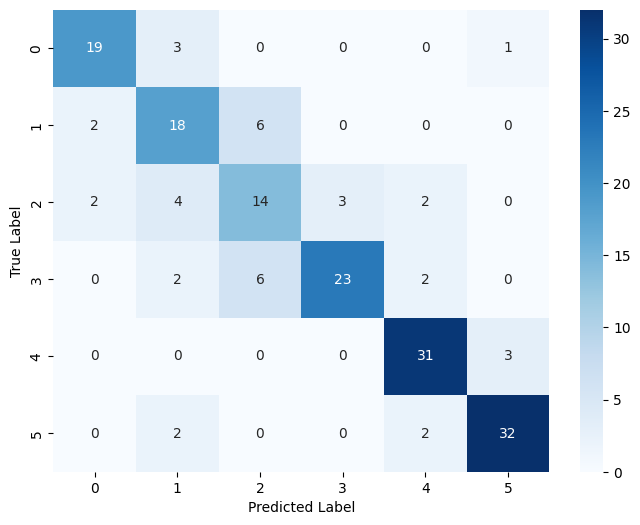

In [35]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [36]:
model.save('B_value_model.h5')



model.output_names=['output']
input_signature = [tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype, name='digit')]

# Convert the Keras model to ONNX format
#onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=input_signature, opset=13)


(onnx_model_proto, storage) = tf2onnx.convert.from_keras(model,input_signature=input_signature, opset=13)
with open('modelData.onnx', "wb") as f:
    f.write(onnx_model_proto.SerializeToString())